In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# A bunch of utility functions

def show_array_images(images, title = ''):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    
    plt.suptitle(title)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
def imgshow(array_image):
    """ Show one array image as uint8 and remove axis labels """
    sqrtimg = int(np.ceil(np.sqrt(array_image.shape[0])))
    imshow_noax(array_image.reshape([sqrtimg,sqrtimg]), normalize=True)

def array_to_image(array):
    sqrtimg = int(np.ceil(np.sqrt(array.shape[0])))
    x = np.array(array.reshape([sqrtimg,sqrtimg]))
    return x
    
def image_to_array(image):
    l = image.shape[0]*image.shape[1]
    x = np.array(image.reshape([l]))
    return x

def center_square(array_image, square_h, square_w, pixel_value = 0.3):
    img = array_to_image(array_image)
    h, w = img.shape                     
    j = int(round((h - square_h)/2.))
    i = int(round((w - square_w)/2.))
    img[j:j+square_h, i:i+square_w] = pixel_value
    img = image_to_array(img)
    return img

def mask_images(array_images, masktype, *args):
    """ Retruns an array of image and masked image pairs """
    masked_images = []
    for array_image in array_images:
        if masktype == 'square':
            masked = center_square(array_image,*args)
        masked_images.append(array_image)
        masked_images.append(masked)
    return np.array(masked_images)

#utility functions for GANs

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

from itertools import izip

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return izip(a, a)

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/MNIST', one_hot=False)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


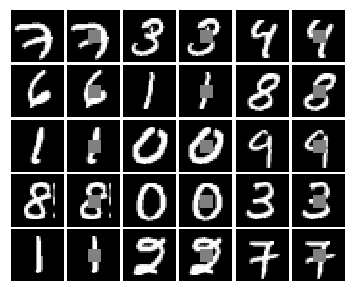

In [4]:
#Mask
mask = np.zeros(mnist.train.images[0].shape)
mask = center_square(mask,7,7)
rounded_mask = center_square(mask,7,7,1)

#Generating anomalies in images
masked_images = mask_images(mnist.train.images[0:15],'square',7,7, 0.5)
#masked_images = mask_images(mnist.train.next_batch(16),'square',10,10)
show_array_images(masked_images)

In [5]:
#Restore a model
tf.reset_default_graph()
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('../models/mnist_dcgan/mnist_dcgan.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('../models/mnist_dcgan/'))

INFO:tensorflow:Restoring parameters from ../models/mnist_dcgan/mnist_dcgan.ckpt


In [6]:
#Find the nodes in the graph
graph = tf.get_default_graph()

#input of first operation we want to restore: generator = genertor input
#gi = graph.get_tensor_by_name("random_uniform/mul:0")
gi = graph.get_tensor_by_name("random_normal/mul:0")

#output of last operation we want to restore: discriminator = generator output
go = graph.get_tensor_by_name("generator/last_op_generator:0")
#go = graph.get_tensor_by_name("generator/Reshape_1:0")

#Generator loss
gl = graph.get_tensor_by_name("generator_loss:0")
#gl = graph.get_tensor_by_name("Mean_2:0")

#Discriminator feature layer output
dfl = graph.get_tensor_by_name('discriminator/dense_layer/Maximum:0')

#Discriminator input
di = graph.get_tensor_by_name('sub:0')

In [7]:
def generator(z,gi,go):
    G_sample = sess.run(go, feed_dict={gi: z})
    return G_sample

In [8]:
def features(image):
    features = sess.run(dfl,feed_dict={di: np.reshape(image, [-1,784])})
    return features

In [9]:
# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96
#input dimensions
image_shape = go.shape[1:].as_list()

#Variables 
z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=-0.5))

# Generated images
G_sample = generator(z,gi,go)

#Get solver
z_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5)

#Get loss
alpha = 0.5
beta = 100

with graph.as_default():
    images = tf.placeholder(tf.float32,image_shape, name='images') 
    xf = tf.placeholder(tf.float32,[1,1024], name='x_features') 
    
    #define loss
    L2_loss = tf.nn.l2_loss(go-images)
    perceptual_loss = tf.nn.l2_loss(dfl-xf)
    z_loss = alpha*L2_loss + (1-alpha)*beta*perceptual_loss
    z_grads = tf.gradients(z_loss, gi)

In [10]:
def z_search(z, x, real_x, features, alpha,beta, nIter = 3000, v = 0, momentum = 0.9, adam = False, nesterov = False,
             lr = 0.001, print_every = 250, show_every = 500, multiple_images = False, decay_every  = 1000, 
             m = 0):
    
    loss_history = []
    show_history = []
    
    for i in range(nIter):
        out_vars = [L2_loss, perceptual_loss, z_loss, z_grads, go]
        in_dict = {gi: z, images: preprocess_img(x), xf: features, di: generator(z,gi,go) }

        loss1, loss2, loss, grad, imout = sess.run(out_vars, feed_dict=in_dict)
            
        #step decay
        if (i % decay_every == 0):
            lr = 0.5*lr
            
        if nesterov:    
            #Nesterov
            v_prev = np.copy(v)
            v = momentum*v - lr*grad[0]
            z += (-momentum * v_prev +
                       (1 + momentum) * v)
            z = np.clip(z, -1, 1)
        
        if adam:
            eps = 1e-8
            beta1 = 0.9
            beta2 = 0.999
            # Adam t is your iteration counter going from 1 to infinity
            dx = grad[0]
            t = i+1
            m = beta1*m + (1-beta1)*dx
            mt = m / (1-beta1**t)
            v = beta2*v + (1-beta2)*(dx**2)
            vt = v / (1-beta2**t)
            z += - lr * mt / (np.sqrt(vt) + eps)        
        
        #Mean image
        mean = np.mean(imout, axis = 0)
        mean = deprocess_img(mean)
        
        if not(multiple_images):
            if (i % print_every == 0):
                print('Iteration {}: {}, l2: {}, pl:{}'.format(i, loss, alpha*loss1, (1-alpha)*beta*loss2))
        
            if (i % show_every == 0):
                show = np.array([real_x,x,imout[0],mean])
                show_array_images(show)
                plt.show()
        else:
            if (i % show_every == 0):
                show_history.append(np.array([real_x,x,imout[0],mean]))
            
        loss_history.append(loss)
        
    if not(multiple_images):     
        #final print
        print('Final images:')
        show = np.array([real_x,x,imout[0],mean])
        show_array_images(show)
        plt.show()
    
    return imout, loss_history, mean

Iteration 0: 17077.0, l2: 11813.2626953, pl:5263.73672485


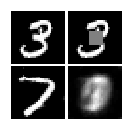

Iteration 250: 12022.4951172, l2: 3460.66308594, pl:8561.83166504


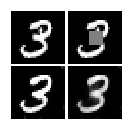

Iteration 500: 11764.2158203, l2: 2525.46899414, pl:9238.74664307


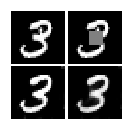

Iteration 750: 11453.6708984, l2: 1952.35522461, pl:9501.31530762


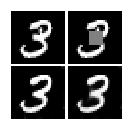

Iteration 1000: 11065.7050781, l2: 1823.46411133, pl:9242.24090576


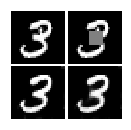

Iteration 1250: 11011.6220703, l2: 1803.09997559, pl:9208.52203369


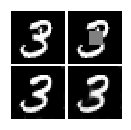

Iteration 1500: 10834.9365234, l2: 1763.33178711, pl:9071.60415649


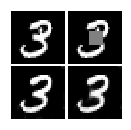

Iteration 1750: 10758.9892578, l2: 1733.11035156, pl:9025.87890625


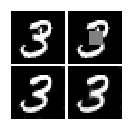

Final images:


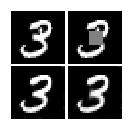

In [18]:
#Search in latent space
#z = sess.run(tf.random_uniform([batch_size, noise_dim], minval=-1, maxval=1))
z = sess.run(tf.random_normal([batch_size, noise_dim], mean=0, stddev=1))

real_x = masked_images[2]
x = masked_images[3]
fts = features(x)

imout,loss_history, mean = z_search(z, x,real_x,fts, alpha, beta, nIter=2000, show_every=250, 
                                    print_every=250, lr = 1e-2, decay_every = 800, adam = False, nesterov = True)

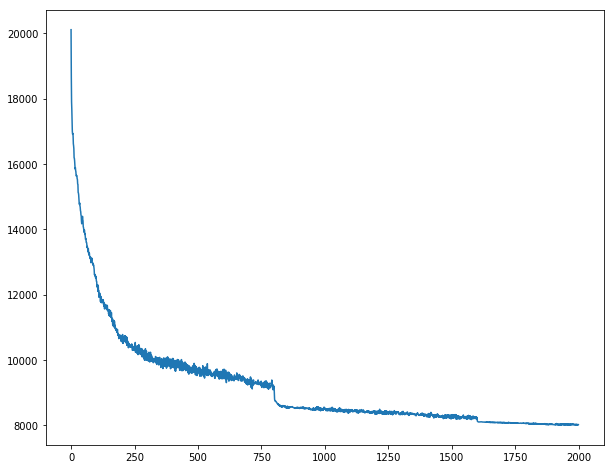

In [14]:
plt.plot(loss_history)
plt.show()

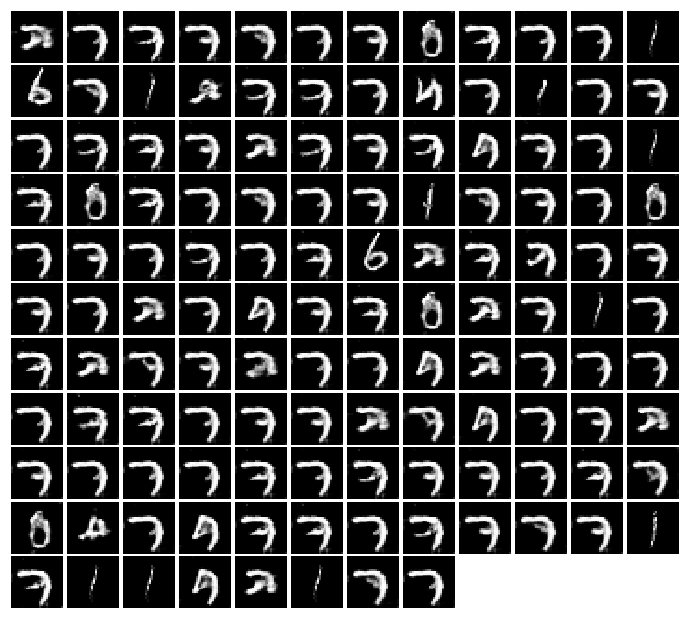

In [15]:
show_array_images(imout)

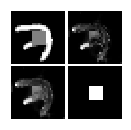

In [16]:
#Mean anomaly
result1 = np.abs(mean-x)
mean_anomaly = np.mean(np.abs(deprocess_img(imout)-x), axis=0)

show = np.array([x,result1, mean_anomaly, mask])
show_array_images(show)

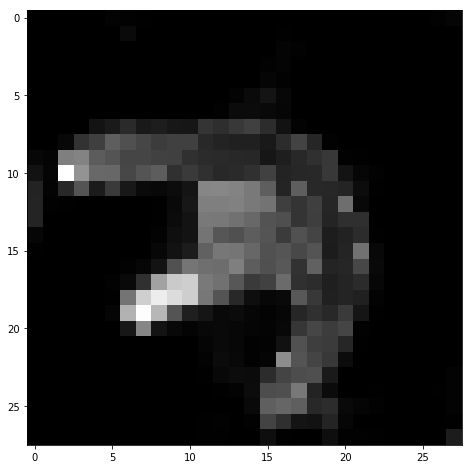

In [17]:
#Postprocess anomaly
plt.imshow(array_to_image(mean_anomaly))

In [18]:
def rescale(a):
    return (a - np.min(a))/(np.max(a)-np.min(a))

In [ ]:
def postporcess(mean_anomaly, ksize=2, threshold = 0.55):
    ker = np.ones((ksize,ksize))
    a = convolve2d(array_to_image(mean_anomaly), ker, mode='same', boundary='symm')
    a = rescale(a)
    a = np.where(a >= threshold, 1,0)
    predicted_mask = image_to_array(a)
    return predicted_mask

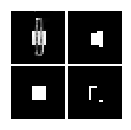

In [19]:
from scipy.signal import convolve2d
ker = np.ones((2,2))
a = convolve2d(array_to_image(mean_anomaly), ker, mode='same', boundary='symm')
a = rescale(a)
threshold = 0.55
a = np.where(a >= threshold, 1,0)
predicted_mask = image_to_array(a)
show = np.array([mean_anomaly,predicted_mask,rounded_mask, np.abs(rounded_mask-predicted_mask)] )
show_array_images(show)

In [20]:
#Jacquard index
def int_and_union(predicted, ground_truth):
    intersection = np.multiply(predicted,ground_truth)
    union = predicted + ground_truth
    union = np.clip(union,0,1)
    return intersection, union

def int_over_union(predicted, ground_truth):
    intersection = np.sum(np.multiply(predicted,ground_truth))
    union = predicted + ground_truth
    union = np.sum(np.clip(union,0,1))
    return intersection/union

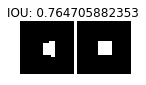

In [21]:
show = np.array([predicted_mask,rounded_mask])
show_array_images(show, title = 'IOU: {}'.format(int_over_union(predicted_mask,rounded_mask)))

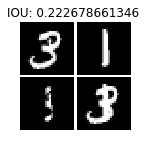

In [28]:
img1, img2 = masked_images[2], masked_images[24]
intersection, union = int_and_union(img1,img2)
show = np.array([img1,img2, intersection,union])
show_array_images(show, title = 'IOU: {}'.format(int_over_union(img1,img2)))

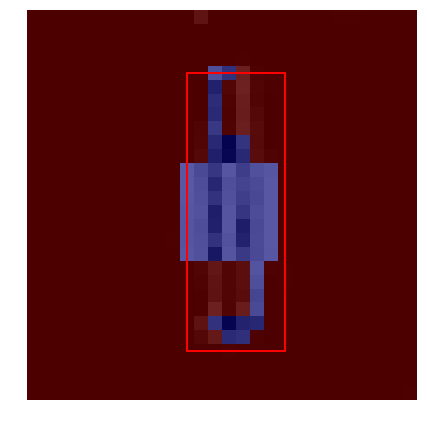

In [381]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


image = array_to_image(mean_anomaly)

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 50:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [303]:
#Saliency Map for perceptual loss
saliency = None 

real_x = masked_images[2]
x = masked_images[3]
fts = features(preprocess_img(imout[0]))

with graph.as_default(): 
    xf = tf.placeholder(tf.float32,[1,1024], name='x_features')
    perceptual_loss = tf.nn.l2_loss(dfl-xf)
    dx = tf.gradients(perceptual_loss, di)
    dx = tf.squeeze(dx)
    dx = dx[0]
    #abs_dx = tf.abs(dx[0])

In [304]:
saliency = sess.run(dx, feed_dict={xf: fts, di: np.tile(preprocess_img(x),(128,1))})

In [308]:
type(saliency)

numpy.ndarray

In [306]:
# rescale to 0 1
#saliency = np.abs(saliency)
saliency = (saliency - np.min(saliency))/(np.max(saliency)-np.min(saliency))

In [326]:
result2 = np.abs(x-saliency)
#result2 = (result2 - np.min(result2))/(np.max(result2)-np.min(result2))

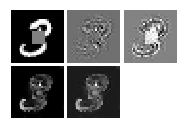

In [337]:
show = np.array([x, saliency, -result2, result1, result])
show_array_images(show)

In [336]:
#Compare results
lamb = 0.8
result = lamb*result1 - (1-lamb)*result2

In [1]:
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#img1 = mpimg.imread('image1.png')
#img2 = mpimg.imread('image2.png')
img1 = array_to_image(rounded_mask)
img2 = array_to_image(result)

#img1 = np.stack((img1,)*3)
#img2 = np.stack((img2,)*3)

# Calculate the absolute difference on each channel separately
error_r = np.fabs(np.subtract(img2[:,:], img1[:,:]))
error_g = np.fabs(np.subtract(img2[:,:], img1[:,:]))
error_b = np.fabs(np.subtract(img2[:,:], img1[:,:]))

# Calculate the maximum error for each pixel
lum_img = np.maximum(np.maximum(error_r, error_g), error_b)

# Uncomment the next line to turn the colors upside-down
#lum_img = np.negative(lum_img);

imgplot = plt.imshow(lum_img)

# Choose a color palette
imgplot.set_cmap('jet')
#imgplot.set_cmap('Spectral') 

plt.colorbar()
plt.axis('off')

pylab.show()

NameError: name 'array_to_image' is not defined

In [72]:
#Study preceptual loss
#real = mnist.train.images[3]
real = masked_images[7]
f = features(real)
images = mnist.train.images[0:5000]

In [73]:
dif = []
for img in images:
    ft = features(img)
    dif.append(np.linalg.norm(ft -f))
    #show = np.array([real, img])
    #show_array_images(show, title = 'Difference {}'.format(dif))

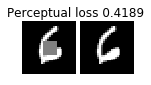

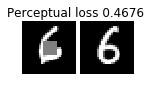

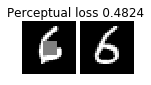

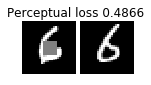

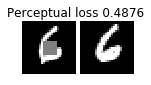

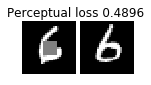

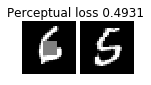

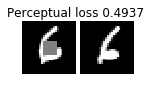

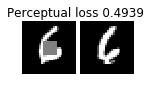

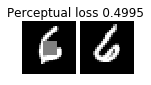

In [74]:
#Best and worst
idx = np.argsort(dif)
for i in idx[:10]:
    img = images[i]
    d = dif[i]
    show = np.array([real, img])
    show_array_images(show, title = 'Perceptual loss {0:.4f}'.format(d))

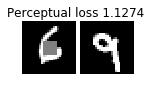

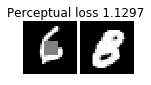

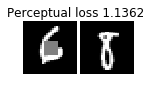

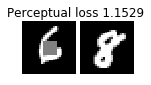

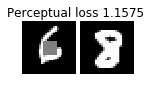

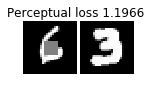

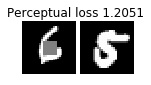

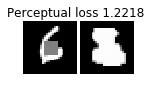

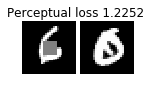

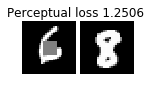

In [75]:
for i in idx[-10:]:
    img = images[i]
    d = dif[i]
    show = np.array([real, img])
    show_array_images(show, title = 'Perceptual loss {0:.4f}'.format(d))